In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import time
import os
import cv2
import torch.nn.functional as F
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object

C:\conda\envs\face_edit\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 加载模型
save_path = './checkpoint/face_gender_classification_transfer_learning_with_ResNet18.pth'

model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2) # binary classification (num_of_class == 2)
model.load_state_dict(torch.load(save_path))
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
def imgPreprocess(img):
    # 转为float32
    img = img.astype(np.float32)
    # 缩放
    img = cv2.resize(img,(224,224))
    # BGR 2 RGB
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    # h,w,c 2 c,h,w
    img = img.transpose((2,0,1))
    # 归一化[0,255] 转 [-1,1]
    img = (img - 127.5) / 127.5
    # 增加维度
    img = np.expand_dims(img,0)
    
    return torch.from_numpy(img).to(device)


In [4]:
def predictGender(imageFile):
    test_img = cv2.imread(imageFile)
    # 预处理
    inputs = imgPreprocess(test_img)
    # 推理
    outputs = model(inputs)
    
    outputs_avg = outputs.view(1, -1).mean(0)  # avg over crops
    _, predicted = torch.max(outputs_avg.data, 0)
    
    label_id = int(predicted.cpu().numpy())
    
    score = F.softmax(outputs_avg,dim=0)
    
    score = score[label_id].cpu().item()
    
    label = 'woman' if label_id == 0 else 'man'
    
    back_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
    return back_img,label,score


(-0.5, 1023.5, 1023.5, -0.5)

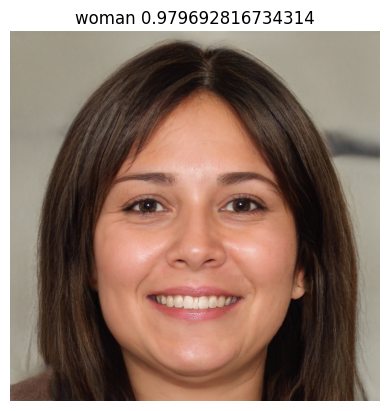

In [5]:
img,label,score = predictGender('./images/fake1.png')
plt.imshow(img)
plt.title(label + ' ' + str(score))
plt.axis('off')

(-0.5, 1023.5, 1023.5, -0.5)

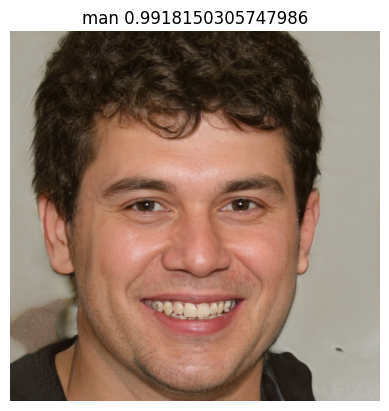

In [6]:
img,label,score = predictGender('./images/fake2.png')
plt.imshow(img)
plt.title(label + ' ' + str(score))
plt.axis('off')